# Air Temperature Forecasting

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'san_diego_weather'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'rain_accumulation',
 'rain_duration',
 'relative_humidity']

## Converting TAG Name Format
* After checking all the Tag Names from the San Deigo Daily Weather dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use air_temp tag name.

In [5]:
# Set the desired tag names
tags = ['air_temp']

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'air_temp'


## Load San Deigo Daily Weather dataset
* Load the data using tag names

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'san_diego_weather'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time = quote('2011-09-10 00:00:00')
# Set the data end time
end_time = quote('2014-09-10 23:59:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Move 'value' column to the end
    df['air_temp'] = df.pop('air_temp')

    # Resample data at 1-hour intervals
    df = df.resample('1H').mean()
    
    return df

In [8]:
# Load data
df = data_load(table, name, start_time, end_time, timeformat)
df

NAME,air_temp
TIME,
2011-09-10 00:00:00,63.746
2011-09-10 01:00:00,63.152
2011-09-10 02:00:00,65.006
2011-09-10 03:00:00,67.271
2011-09-10 04:00:00,65.696
...,...
2014-09-10 19:00:00,76.088
2014-09-10 20:00:00,75.497
2014-09-10 21:00:00,75.086


In [9]:
# Train data: from 2011 to 2014.08.31
# Test data: 2014.09

train = df[df.index < '2014-09-01']
test = df[(df.index > '2014-09-01')]

## Data Preprocessing
* 1 Min-Max Scaling

### 1. Applying Min-Max Scaling
* Apply to both input data and target data separately to facilitate conversion back to original values after testing. 

In [10]:
# Set up scalers
scaler = MinMaxScaler()

# Apply scalers
train_t = scaler.fit_transform(train.values)

test_t = scaler.transform(test.values)

# Set each DataFrames
train_scaled = pd.DataFrame()  
train_scaled['air_temp'] = train_t.reshape(-1)

test_scaled = pd.DataFrame()
test_scaled['air_temp'] = test_t.reshape(-1)

## Dataset & Loader Setup
- This function creates sliding windows of historical data for input and corresponding future values for forecast based on the specified window size and forecast size.

In [11]:
# Sliding Window Dataset Configuration
def time_slide_df(df, window_size, forecast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forecast_size+1):
        x = df_.iloc[idx:idx+window_size].values.reshape(window_size, df.shape[1])
        y = df_.iloc[idx+window_size:idx+window_size+forecast_size].values
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [12]:
# Sliding window configuration
# Window size: How many past data points will be used
# Forecast: How many future data points to forcast
window_size = 10
forecast_size= 5

# Set up datasets 
train_x, train_y = time_slide_df(train_scaled, window_size, forecast_size)
test_x, test_y = time_slide_df(test_scaled, window_size, forecast_size)

train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)

train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle=False)
test_dataloader = DataLoader(test_ds,  batch_size = 64, shuffle=False)

In [13]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([64, 10, 1])


## Model Configuration
* Using DLinear model.

In [14]:
## modeling
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - 0.3*moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forecast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size

        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:

            trend_output = self.Linear_Trend(trend_init)

            seasonal_output = self.Linear_Seasonal(seasonal_init)
            
        x = seasonal_output + trend_output
        return x.permute(0,2,1)

In [15]:
# Model configuration parameters

# Learning rate
lr = 0.001

# Model configuration
model = LTSF_DLinear(
                    window_size=window_size,
                    forecast_size=forecast_size,
                    kernel_size=25,
                    individual=False,
                    feature_size=1
                    ).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

LTSF_DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Trend): Linear(in_features=10, out_features=5, bias=True)
  (Linear_Seasonal): Linear(in_features=10, out_features=5, bias=True)
)


## Model Training

* Save the model with the Best Loss based on the validation data during training.

In [16]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        data = data.to(device).float()
        target = target.to(device).float()
        
        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(data)

        # Calculate loss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/San_Diego_Daily_Weather_General.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.012014863362042782
Model saved

train loss: 0.008104099701130525
Model saved

train loss: 0.006629154412605969
Model saved

train loss: 0.005811346683604127
Model saved

train loss: 0.00526991207702983
Model saved

train loss: 0.004877375856713665
Model saved

train loss: 0.004577803724839126
Model saved

train loss: 0.004341421348671276
Model saved

train loss: 0.004150206724786153
Model saved

train loss: 0.003992383247815296
Model saved

train loss: 0.003859882718507775
Model saved

train loss: 0.003746998458335224
Model saved

train loss: 0.003649603738249267
Model saved

train loss: 0.0035646545830287936
Model saved

train loss: 0.003489855661963452
Model saved

train loss: 0.0034234455421170928
Model saved

train loss: 0.003364055944803008
Model saved

train loss: 0.003310608003741068
Model saved

train loss: 0.0032622375280104096
Model saved

train loss: 0.003218242678155891
Model saved

train loss: 0.003178046789488019
Model saved

train loss: 0.00314117126334077

## Model Testing

In [17]:
# Load the best model
model_ = torch.load(f'./result/San_Diego_Daily_Weather_General.pt')

In [24]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, (data, target) in enumerate(test_dataloader):
        
        data_t = data.to(device).float()
        target_t = target.to(device).float()

        outputs_t = model_(data_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[:,:1].cpu()
last_values_pred = combined_tensor_pred[:,:1].cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [25]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 2.104762
R² Score: 0.9381215627338713


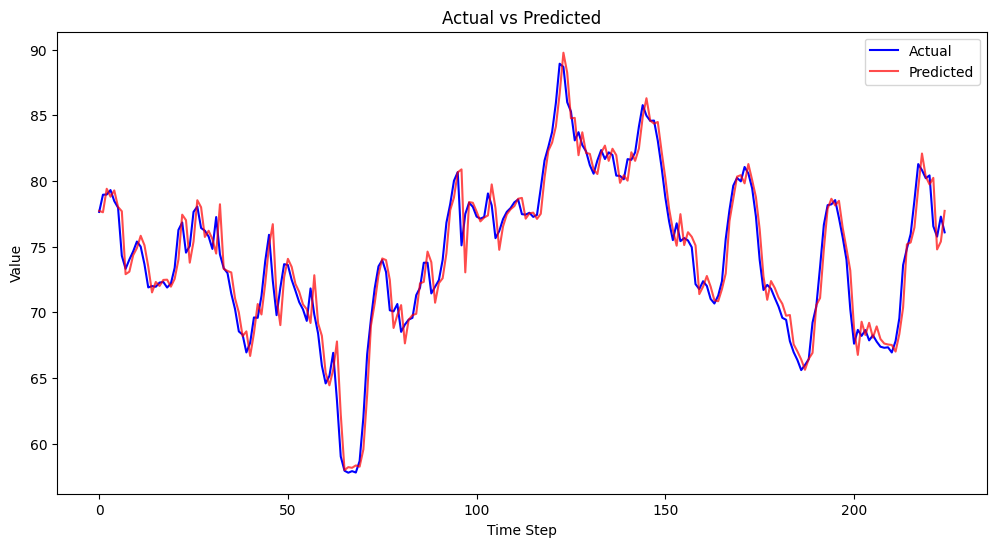

In [26]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()